<a href="https://colab.research.google.com/github/marinmaletic/Final-thesis-2022./blob/main/Final_thesis2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic image segmentation for application in environment exploration

**Author:** Marin Maletić<br>
**Date created:** 01/05/2022<br>
**Last modified:** 30/06/2022<br>
**Motivation:** Bachelor's degree final thesis - Faculty of electrical engineering and computing, University of Zagreb.<br>
**Description:** Implement DeepLabV3+ architecture for Multi-class Semantic Segmentation.

### References:

The following code is a combination of existing DeepLabV3+ architectures modified to be trained on [Cityscapes Dataset](https://www.cityscapes-dataset.com/dataset-overview/) and tested on roads in Zagreb, Croatia

- [Multiclass semantic segmentation using DeepLabV3+](https://keras.io/examples/vision/deeplabv3_plus/)
- [Semantic Mapping for Manipulation
Through Interaction](https://github.com/Matija-KK/deeplab_v3p.git)

## Downloading the data

We will use the [Cityscapes Dataset](https://www.cityscapes-dataset.com/dataset-overview/)
for training our model. The Cityscapes dataset has 5 000 annotated images of roads for semantic understanding of urban street scenes. <br> 
Data was captured in 50 cities during several months, daytimes, and good weather conditions.
It provides semantic, instance-wise, and dense pixel annotations for 34 classes grouped into 8 categories (flat surfaces, humans, vehicles, constructions, objects, nature, sky, and void). <br>
****
For the purpose of this work, a new dataset was created using around 1100 images and its annotations from the Cityscapes dataset and couple of test pictures captured in the streets of Zagreb.

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage import color

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!gdown https://drive.google.com/uc?id=1FTX66A3IOU9aJZWYGMBnk-8Vvyy2UqlE
!unzip -q zavrsni_dataset.zip 

Downloading...
From: https://drive.google.com/uc?id=1FTX66A3IOU9aJZWYGMBnk-8Vvyy2UqlE
To: /content/zavrsni_dataset.zip
100% 2.59G/2.59G [00:25<00:00, 101MB/s]


## Creating a TensorFlow Dataset

A dataset will be created containing a 1000 images for training and 50 images for validation of the model.

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 34
DATA_DIR = "./zavrsni_dataset/"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50
NUM_TEST_IMAGES = 3

train_images = sorted(glob(os.path.join(DATA_DIR, "train/Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "train/Categories/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/Images/*")))[NUM_TRAIN_IMAGES : 
                                                                    NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "train/Categories/*")))[NUM_TRAIN_IMAGES 
                                                                       : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
test_images = sorted(glob(os.path.join(DATA_DIR, "test/Images/*")))[:NUM_TEST_IMAGES]
test_masks = sorted(glob(os.path.join(DATA_DIR, "test/Categories/*")))[:NUM_TEST_IMAGES]

CLASSES_minmax_values = {"Road": (6.9, 7.1),     # Grayscale
                         "Sidewalk": (7.9, 8.1),
                         "Building": (10.9, 11.1),
                         "Car": (25.9, 26.1)}


COLORMAP_PATHS = {"Road": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_roads.mat")),     
                  "Sidewalk": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_sidewalks.mat")),
                  "Building": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_buildings.mat")),
                  "Car": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_cars.mat")),
                  "All": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_roads_sidewalks_buildings_cars.mat")),
                  "All34": glob(os.path.join(DATA_DIR, "colormaps/cityscapes_colormap_34_classes.mat"))}



def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the sampling rate becomes larger, the number of valid filter weights (i.e., weights that are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## Training the model

We train the model using sparse categorical crossentropy as the loss function, and Adam as the optimizer.<br>
***
Training the model lasts for about 50 minutes.<br>
If you would like to skip the training process, an already trained model is saved and can be loaded in the next section.

Epoch 1/25
250/250 [==============================] - 119s 414ms/step - loss: 0.9236 - accuracy: 0.7692 - val_loss: 2.1249 - val_accuracy: 0.5469
Epoch 2/25
250/250 [==============================] - 106s 422ms/step - loss: 0.5711 - accuracy: 0.8444 - val_loss: 1.4290 - val_accuracy: 0.6182
Epoch 3/25
250/250 [==============================] - 107s 426ms/step - loss: 0.4418 - accuracy: 0.8766 - val_loss: 0.8551 - val_accuracy: 0.7726
Epoch 4/25
250/250 [==============================] - 108s 432ms/step - loss: 0.3597 - accuracy: 0.8986 - val_loss: 0.5808 - val_accuracy: 0.8419
Epoch 5/25
250/250 [==============================] - 109s 433ms/step - loss: 0.3106 - accuracy: 0.9117 - val_loss: 0.4958 - val_accuracy: 0.8656
Epoch 6/25
250/250 [==============================] - 109s 434ms/step - loss: 0.2840 - accuracy: 0.9183 - val_loss: 0.4802 - val_accuracy: 0.8664
Epoch 7/25
250/250 [==============================] - 107s 426ms/step - loss: 0.2664 - accuracy: 0.9229 - val_loss: 0.4234 -

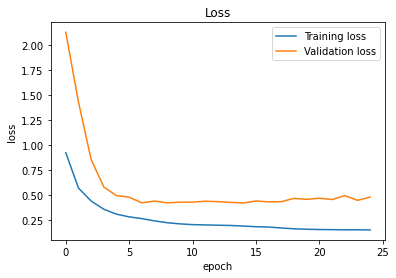

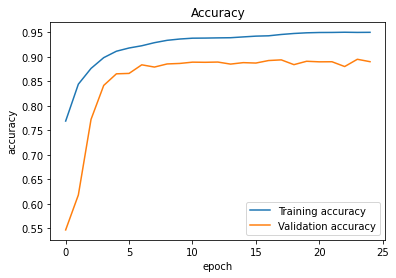

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

plt.plot(history.history["loss"], label='Training loss')
plt.plot(history.history["val_loss"], label='Validation loss')
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label='Training accuracy')
plt.plot(history.history["val_accuracy"], label='Validation accuracy')
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

####Save/load the model
Save the model for later usage without training or load an already trained model.


In [ ]:
#!mkdir -p saved_model
#model.save('saved_model/zavrsni2022_model')

In [ ]:
# Download the trained model to skip the training process
!gdown https://drive.google.com/uc?id=1-7WMiRo9WPivjhnrxyH2DV4gz0DvR99d
!unzip -q saved_model.zip 

Downloading...
From: https://drive.google.com/uc?id=1-7WMiRo9WPivjhnrxyH2DV4gz0DvR99d
To: /content/saved_model.zip
100% 131M/131M [00:00<00:00, 162MB/s]


In [ ]:
model = tf.keras.models.load_model('./saved_model/zavrsni2022_model')

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 34)`
where each one of the 34 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `cityscapes_colormap.mat` file made for this dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./zavrsni_dataset/colormaps/cityscapes_colormap_roads_sidewalks_buildings_cars.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 34)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )
    return 

### Inference on Train Images

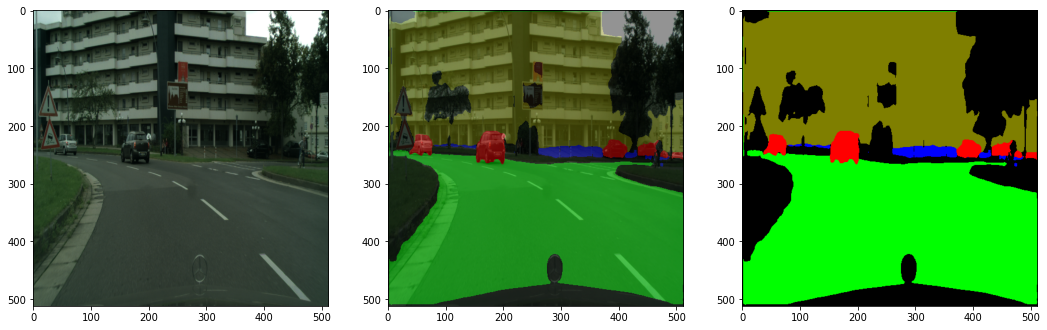

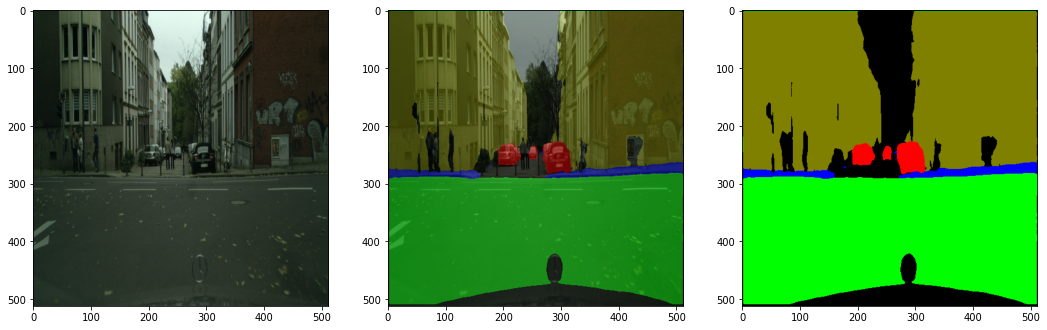

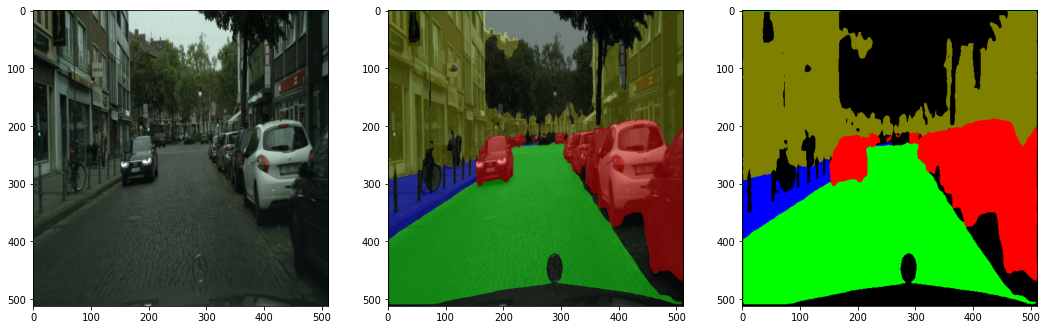

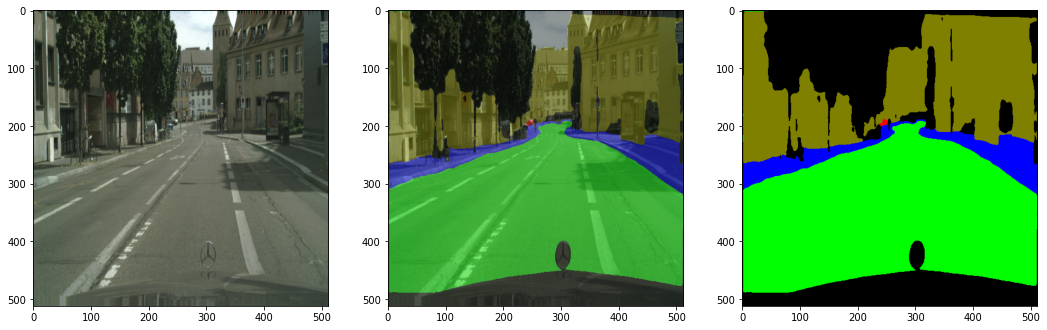

In [ ]:
plot_predictions(train_images[:4], colormap, model=model)

### Inference on Validation Images

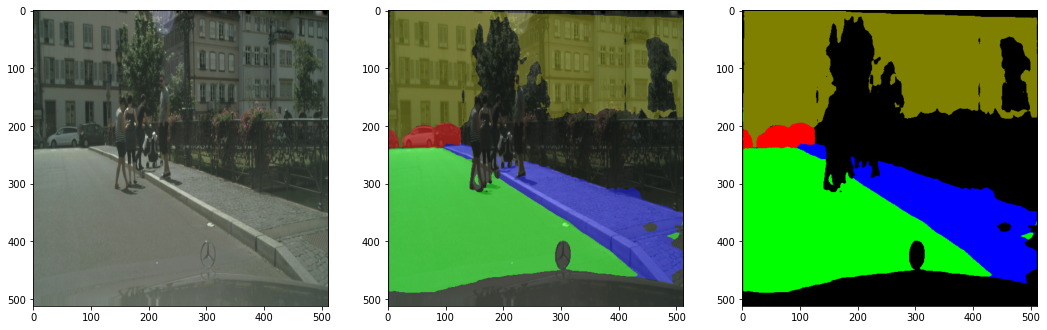

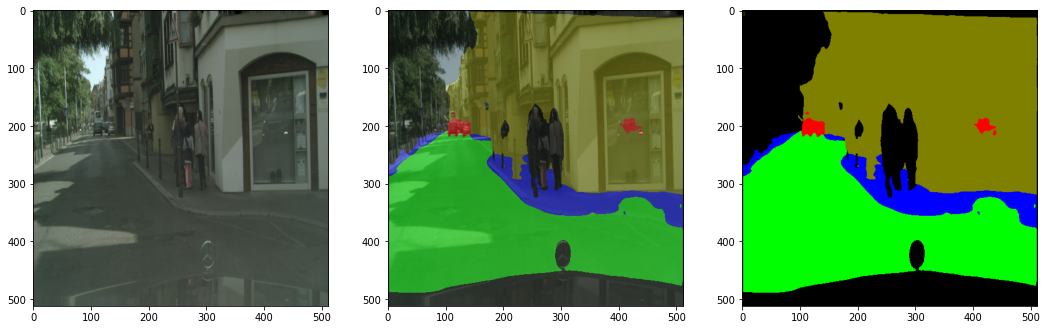

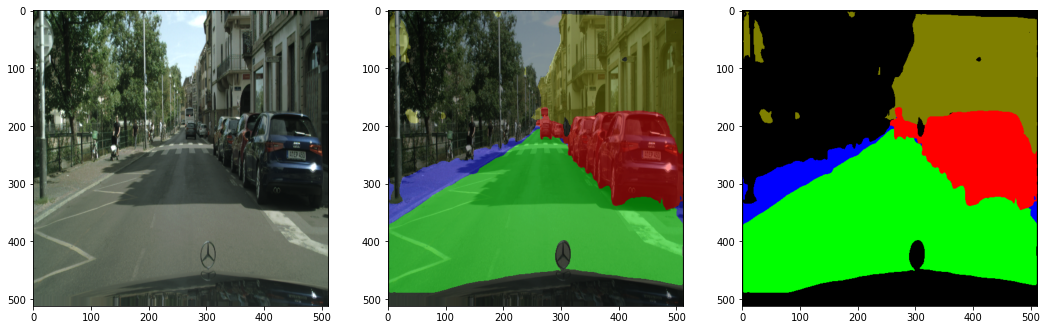

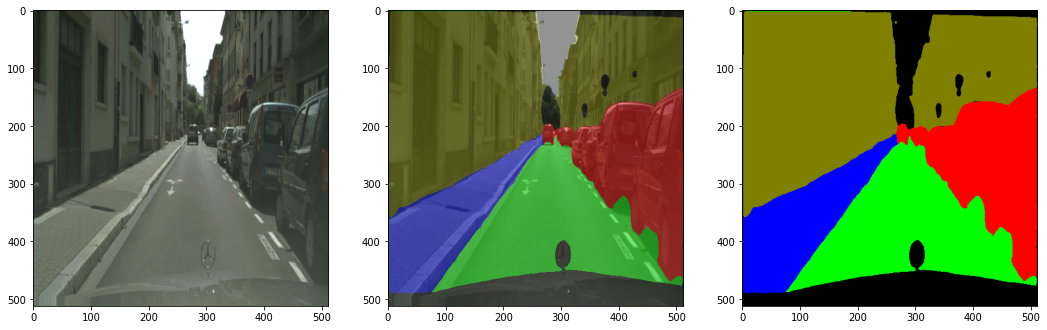

In [ ]:
plot_predictions(val_images[:4], colormap, model=model)

### Inference on Test images

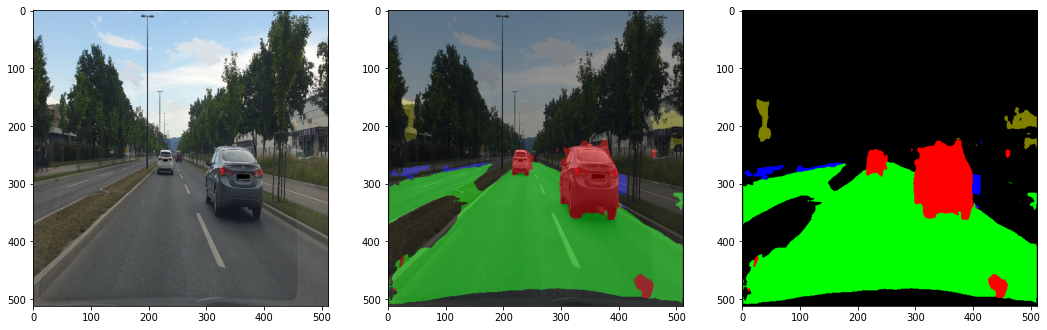

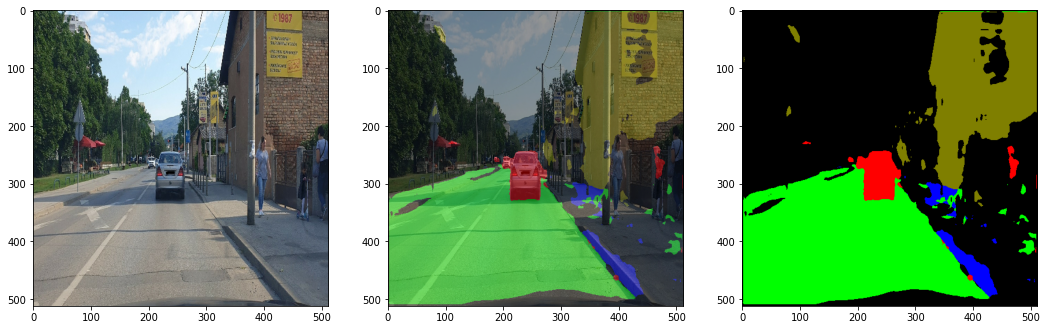

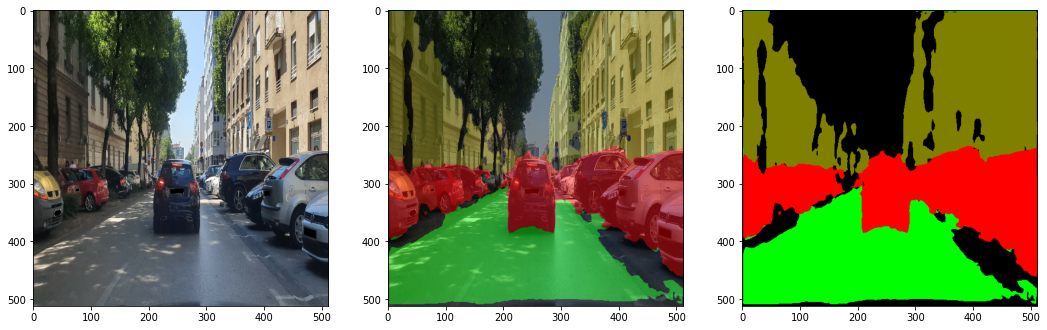

In [ ]:
plot_predictions(test_images[:3], colormap, model=model)

## Metrics to Evaluate Semantic Segmentation Model

To evaluate the network’s performances on the single validation and test image, the **Intersection over Union** metric is used. The IoU metrics is also known as the Jaccard distance, and it estimates the overlap percentage between the ground truth and predicted semantic masks for all defined classes separately.<br>

![](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)



In [ ]:

def IoU(image, ground_truth, class_name, plot):

    """
    Read an image and make a prediction using trained model.
    The model makes a prediction of all 34 classes so using an appropriate 
    colormap we color only the class in our focus of interest, all other classes 
    are colored black.

    """
    colormap = loadmat(COLORMAP_PATHS[class_name][0])["colormap"] * 100
    colormap = colormap.astype(np.uint8)

    image_tensor = read_image(image)
    prediction_mask = infer(image_tensor=image_tensor, model=model)
    prediction_1class_colormap = decode_segmentation_masks(prediction_mask, colormap, 34)
    prediction_1class_grayscale = color.rgb2gray(prediction_1class_colormap)

    """
    Cityscapes dataset ground truth images contain all 34 classes annotated.
    Using threshold we single out only the desired class, setting its pixel 
    values to 255.

    """
    ground_truths = read_image(ground_truth)
    ground_truths_grayscale = (color.rgb2gray(ground_truths) + 1) * 127.5
    (thresh, binary_down) = cv2.threshold(ground_truths_grayscale, 
                                          CLASSES_minmax_values[class_name][0], 
                                          255, cv2.THRESH_BINARY)
    
    (thresh2, binary_up) = cv2.threshold(ground_truths_grayscale, 
                                         CLASSES_minmax_values[class_name][1], 
                                         255, cv2.THRESH_BINARY_INV)
    
    singled_ground_truth = np.logical_and(binary_up, binary_down)

    """ Calculate intersection over union: """

    intersection = np.logical_and(singled_ground_truth, prediction_1class_grayscale)
    union = np.logical_or(singled_ground_truth, prediction_1class_grayscale)
    iou_score = np.sum(intersection) / np.sum(union)

    if plot and iou_score > 0.01:
        _, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 14))
        axes[0].imshow(singled_ground_truth, cmap="gray")
        axes[0].set_title('{} ground truth'.format(class_name))
        axes[1].imshow(prediction_1class_grayscale, cmap="gray")
        axes[1].set_title('{} prediction'.format(class_name))
        axes[2].imshow(intersection, cmap="gray")
        axes[2].set_title('Truth ∩ Prediction')
        axes[3].imshow(union, cmap="gray")
        axes[3].set_title('Truth ∪ Prediction')
        plt.show()

    if iou_score > 0.01:
        print('\nIoU score for the class \'{}\' is: {} %\n'.format(class_name, round(iou_score, 4)*100))
    else:
        print('\nThe class \'{}\' was not recognized in this image\n'.format(class_name))

    return iou_score

###IoU on training images


In [ ]:
plot = True                           #plot the ground truths and predictions
IoU(train_images[2], train_masks[2], "Road", plot)
IoU(train_images[2], train_masks[2], "Sidewalk", plot)
IoU(train_images[2], train_masks[2], "Building", plot)
IoU(train_images[2], train_masks[2], "Car", plot)

###IoU on validation images

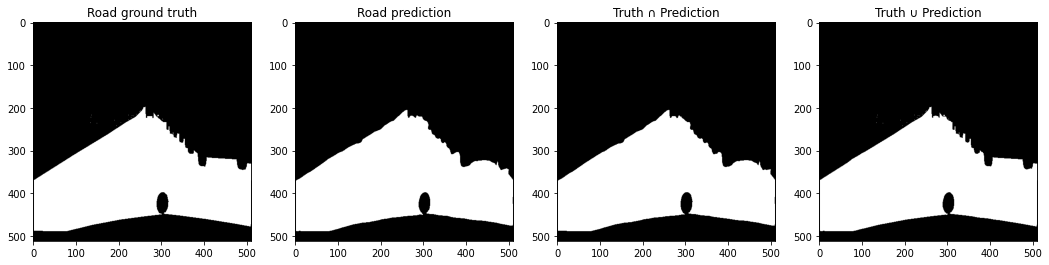


IoU score for the class 'Road' is: 97.39 %



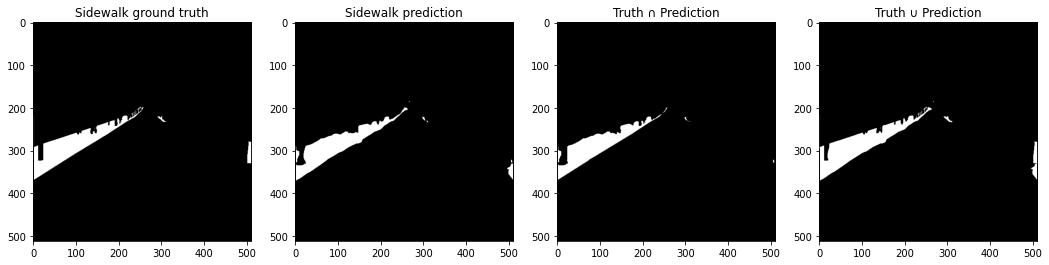


IoU score for the class 'Sidewalk' is: 75.38 %



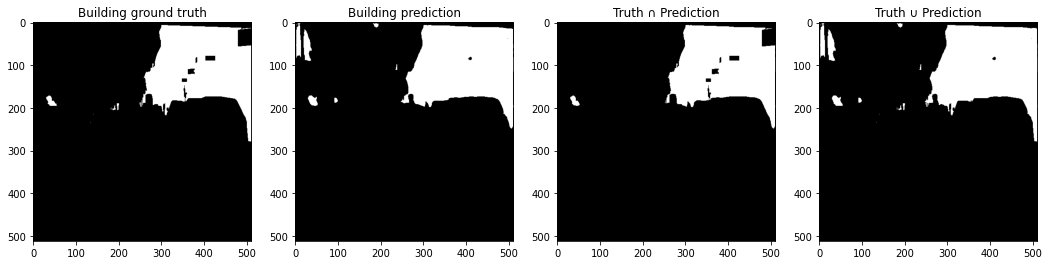


IoU score for the class 'Building' is: 87.91 %



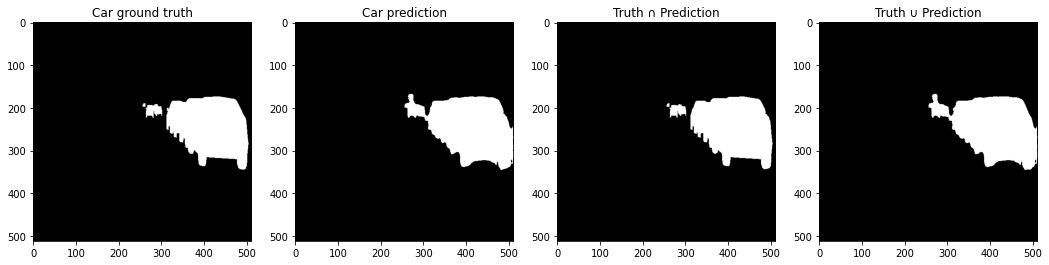


IoU score for the class 'Car' is: 89.79 %



0.897944145604598

In [ ]:
plot = True                           #plot the ground truths and predictions
IoU(val_images[2], val_masks[2], 'Road', plot)
IoU(val_images[2], val_masks[2], 'Sidewalk', plot)
IoU(val_images[2], val_masks[2], 'Building', plot)
IoU(val_images[2], val_masks[2], 'Car', plot)

###IoU on test images

These test images were captured on a sunny day in Zagreb, Croatia.
Class annotations for these images were done manually using [Apeer](https://www.apeer.com/).<br>
As result, poor IoU scores on particular classes can be attributed to shadows and not accurate annotations.

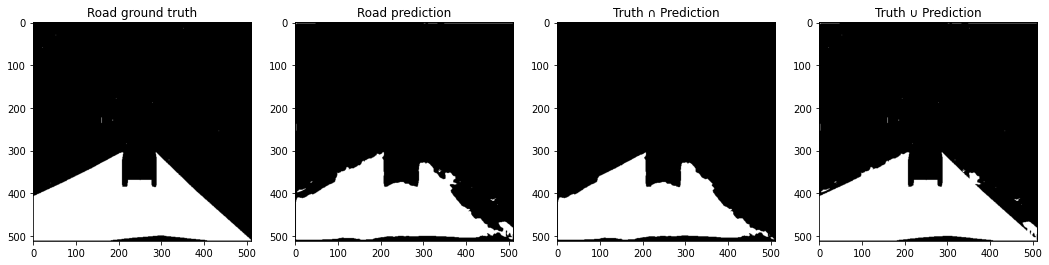


IoU score for the class 'Road' is: 86.16 %


The class 'Sidewalk' was not recognized in this image



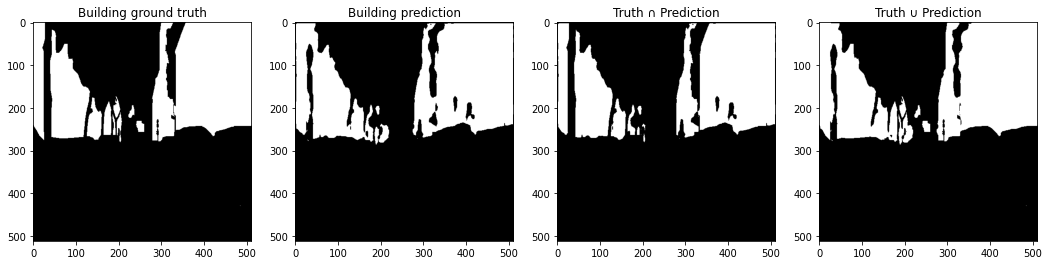


IoU score for the class 'Building' is: 85.78 %



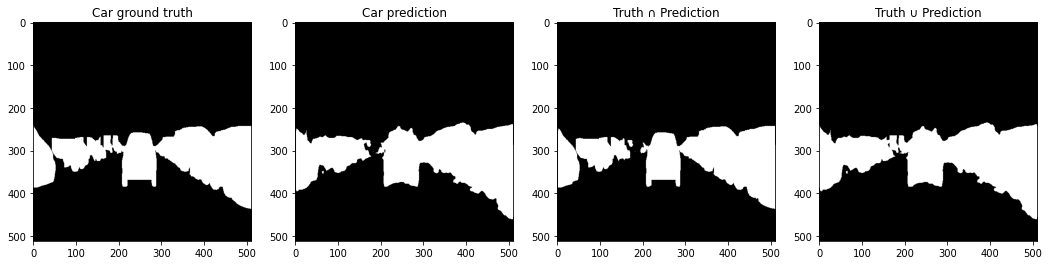


IoU score for the class 'Car' is: 84.78999999999999 %



0.8479241147620502

In [ ]:
plot = True                           #plot the ground truths and predictions
IoU(test_images[2], test_masks[2], 'Road', plot)
IoU(test_images[2], test_masks[2], 'Sidewalk', plot)
IoU(test_images[2], test_masks[2], 'Building', plot)
IoU(test_images[2], test_masks[2], 'Car', plot)